**Model to classify the moview reviews into positive or negative reviews based on Internet review dataset.**

**IMDB dataset** -> contains the text of **50000 movie reviews** from the Internet Movie Database.

**Training set = 25000 reviews, Test set = 25000 reviews.**

The training and test sets are **balanced** -> meaning they contain an equal number of positive and negative reviews.

**Tensorflow hub** is used for transfer Learning.

In [ ]:
# import the necessary packages
from __future__ import absolute_import, division, print_function, unicode_literals
from matplotlib import pyplot as plt
import numpy as np
!pip install tensorflow==2.1.0
import tensorflow as tf

# Pandas is a high-level data manipulation tool
import pandas as pd

# Tensorflow_hub is used for transfer learning
import tensorflow_hub as hub
import tensorflow_datasets as tfds

     |████████████████████████████████| 421.8MB 20kB/s 
     |████████████████████████████████| 3.9MB 41.5MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
     |████████████████████████████████| 450kB 51.4MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=2d615d15da88abf0530c842f4efe754a2391fc278dfee7deb218d3ced4e4ea03
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tens

In [ ]:
print("Version:",tf.__version__)
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately,
# without building graphs: operations return concrete values instead of constructing a computational graph to run later. 
print("Eager mode",tf.executing_eagerly())
print("Hub Version:", hub.__version__)
print("GPU is","AVAILABLE" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Version: 2.1.0
Eager mode True
Hub Version: 0.10.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is AVAILABLE


In [ ]:
#Split the dataset into Training = 60%, Validation = 40%
(train_data,val_data), test_data = tfds.load(name="imdb_reviews", split=[('train[:15000]','train[15000:]'),'test[:25000]'], batch_size=-1, as_supervised=True)
train_examples, train_labels= tfds.as_numpy(train_data)
val_examples, val_labels=tfds.as_numpy(val_data)
test_examples, test_labels=tfds.as_numpy(test_data)
print("Training entries: {}, Validation entries: {}, Test entries: {}".format(len(train_examples), len(val_examples), len(test_examples)))

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteRH9I2F/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteRH9I2F/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteRH9I2F/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
Training entries: 15000, Validation entries: 10000, Test entries: 25000


In [ ]:
#Let us see the first 10 training examples
train_examples[:10]

array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot 

In [ ]:
# Let us see the first 10 training labels
# 1 -> Positive reviews, 0 -> negative reviews
train_labels[:10]

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0])

### Build the model
The neural network is created by stacking layers, it requires three main architectural decisions:

1. How to represent the text?
2. How many layers to use in the model?
3. How many hidden units to use for each layer?

In this example, the input data consists of sentences. The labels to predict are either 0 or 1.

One way to represent the text is to convert sentences into embeddings vectors. 

We can use a pre-trained text embedding as the first layer, which will have two advantages:

1. we don't have to worry about text preprocessing,
2. we can benefit from transfer learning.

For this example we will use a model from TensorFlow Hub called google/tf2-preview/gnews-swivel-20dim/1.

In [ ]:
# Create an embedding layer -> to convert sentences into embedding vectors (dimension = 20)
# The model that we are using (google/tf2-preview/gnews-swivel-20dim/1) splits the sentence into tokens,
# embeds each token and then combines the embedding. The resulting dimensions are: (num_examples, embedding_dimension).
embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
hub_layer = hub.KerasLayer(embedding, output_shape=[20], input_shape=[], 
                           dtype=tf.string, trainable=True)
hub_layer(train_examples[:3])

<tf.Tensor: shape=(3, 20), dtype=float32, numpy=
array([[ 1.765786  , -3.882232  ,  3.9134233 , -1.5557289 , -3.3362343 ,
        -1.7357955 , -1.9954445 ,  1.2989551 ,  5.081598  , -1.1041286 ,
        -2.0503852 , -0.72675157, -0.65675956,  0.24436149, -3.7208383 ,
         2.0954835 ,  2.2969332 , -2.0689783 , -2.9489717 , -1.1315987 ],
       [ 1.8804485 , -2.5852382 ,  3.4066997 ,  1.0982676 , -4.056685  ,
        -4.891284  , -2.785554  ,  1.3874227 ,  3.8476458 , -0.9256538 ,
        -1.896706  ,  1.2113281 ,  0.11474707,  0.76209456, -4.8791065 ,
         2.906149  ,  4.7087674 , -2.3652055 , -3.5015898 , -1.6390051 ],
       [ 0.71152234, -0.6353217 ,  1.7385626 , -1.1168286 , -0.5451594 ,
        -1.1808156 ,  0.09504455,  1.4653089 ,  0.66059524,  0.79308075,
        -2.2268345 ,  0.07446612, -1.4075904 , -0.70645386, -1.907037  ,
         1.4419787 ,  1.9551861 , -0.42660055, -2.8022065 ,  0.43727064]],
      dtype=float32)>

In [ ]:
# Build a Model
# The layers are stacked sequentially to build the classifier.
# The first layer is a TensorFlow Hub layer. This layer uses a pre-trained Saved Model to map a sentence into its embedding vector. 
# This fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units.
# The last layer is densely connected with a single output node. 
# Using the sigmoid activation function, this value is a float between 0 and 1, representing a probability, or confidence level.
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                400020    
_________________________________________________________________
dense (Dense)                (None, 16)                336       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 400,373
Trainable params: 400,373
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# A model needs a loss function and an optimizer for training. 
# Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), 
# we'll use the binary_crossentropy loss function.
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model for 20 epochs
history = model.fit(train_examples, train_labels, shuffle=True, batch_size=512, epochs=20, validation_data = (val_examples,val_labels), verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 4s 270us/sample - loss: 0.8362 - accuracy: 0.5057 - val_loss: 0.7112 - val_accuracy: 0.5567
Epoch 2/20
15000/15000 [==============================] - 2s 148us/sample - loss: 0.6503 - accuracy: 0.6235 - val_loss: 0.6068 - val_accuracy: 0.6763
Epoch 3/20
15000/15000 [==============================] - 2s 147us/sample - loss: 0.5729 - accuracy: 0.7002 - val_loss: 0.5550 - val_accuracy: 0.7185
Epoch 4/20
15000/15000 [==============================] - 2s 146us/sample - loss: 0.5241 - accuracy: 0.7450 - val_loss: 0.5178 - val_accuracy: 0.7501
Epoch 5/20
15000/15000 [==============================] - 2s 148us/sample - loss: 0.4845 - accuracy: 0.7759 - val_loss: 0.4842 - val_accuracy: 0.7775
Epoch 6/20
15000/15000 [==============================] - 2s 147us/sample - loss: 0.4475 - accuracy: 0.8029 - val_loss: 0.4534 - val_accuracy: 0.7974
Epoch 7/20
15000/15000 [==========================

In [ ]:
# Evaluate the model on Test Data
results = model.evaluate(test_examples, test_labels, batch_size=512, verbose=0)
for name, value in zip(model.metrics_names, results):
  print("%s:%.3f" %(name, value))

loss:0.317
accuracy:0.865


In [ ]:
# model.fit() returns a History object that contains a dictionary with everything that happened during training
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

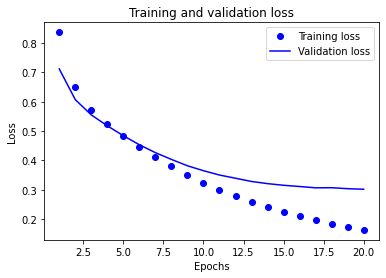

In [ ]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

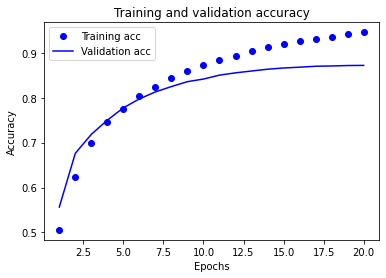

In [ ]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Notice the **training loss decreases with each epoch** and the **training accuracy increases with each epoch**. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the **validation loss and accuracy—they seem to peak after about twenty epochs**. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations specific to the training data that do not generalize to test data.

For this particular case, we could prevent **overfitting** by simply stopping the training after twenty or so epochs. 